In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [2]:
import scipy.stats

In [3]:
import uproot
uproot.default_library = "np"

In [4]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])

In [5]:
B_features = [
    "B_plus_TRUEPT",
    "B_plus_TRUEP_X",
    "B_plus_TRUEP_Y",
]
features = B_features + [
    "e_minus_TRUEPT",
    "e_minus_TRUEP_X",
    "e_minus_TRUEP_Y",
    "e_plus_TRUEPT",
    "e_plus_TRUEP_X",
    "e_plus_TRUEP_Y",
    "K_Kst_TRUEPT",
    "K_Kst_TRUEP_X",
    "K_Kst_TRUEP_Y",
    "q",
]

In [6]:
# https://arxiv.org/abs/2103.11769
aliases = {"q": "J_psi_1S_M", "q2": "J_psi_1S_M**2*1e-6"}
q_nr_selector = join_and("q2 > 1.1", "q2 < 6.0")
q_e_selector = join_and("q2 > 6.0", "q2 < 12.96")
q_mu_selector = join_and("q2 > 8.68", "q2 < 10.09")
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_nr_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)

# example
Jmu_selector

'((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2 > 8.68)&(q2 < 10.09))'

In [7]:
selectors = [Je_selector, Jmu_selector, Kee_selector, Kmumu_selector]

In [8]:
raw_names = [
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    "data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    "data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
]

In [9]:
raw_files = [uproot.open(name) for name in raw_names]

In [10]:
raw_all = [f.arrays(features, aliases=aliases, library="np") for f in raw_files]

In [11]:
raw_b = [f.arrays(features, B_selector, aliases=aliases, library="np") for f in raw_files]

In [12]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [13]:
all_data = [("All", raw_all), ("B", raw_b), ("Truth", truthed)]

In [14]:
df_index = [r"$B \to KJ/\psi(\to ee)$", r"$B \to KJ/\psi(\to\mu\mu)$", r"$B \to Kee$", r"$B \to K\mu\mu$"]
df = pd.DataFrame(index=df_index)

In [15]:
for name, data in all_data:
    df[name] = [b[features[0]].shape[0] for b in data]
df

All        B    Truth
$B \to KJ/\psi(\to ee)$     2084124  1375525   696573
$B \to KJ/\psi(\to\mu\mu)$  3206889  2924782  1459292
$B \to Kee$                  413741   264461    40094
$B \to K\mu\mu$              665455   563948    72469

$R_K=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}$.

In [16]:
def double_ratio(a):
    return (a[3]/a[2])/(a[1]/a[0])

In [17]:
double_ratio(df["Truth"]/df["B"]), double_ratio(df["Truth"]/df["All"])

(0.8602900615354512, 0.8254058791992042)

### Feature tests

$$\begin{aligned}
\textrm{KS}(F,G)
&= \sup_x \left\vert F(x) - G(x)\right\vert
, \\
\textrm{W}_1(F,G)
&=
\sup_{\left\Vert f \right\Vert_L \leq 1} \int_{-\infty}^\infty (F'(x)-G'(x))f(x) dx
\\ &=
\int_{-\infty}^\infty \left\vert F(x) - G(x)\right\vert dx
\\ &=
\int_0^1 \left\vert F^{-1}(u) - G^{-1}(u)\right\vert du
.
\end{aligned}$$

In [18]:
df_test = pd.DataFrame(index=features, columns=[[],[]])

In [19]:
for name, arr in all_data:
    func = lambda f, ix, iy, fn: f(arr[ix][fn], arr[iy][fn]) if fn in arr[ix] and fn in arr[iy] else None
    ks = lambda a1, a2: scipy.stats.kstest(a1,a2).statistic
    df_test[name, 'KSe'] = [func(ks, 2, 0, feature) for feature in df_test.index]
    df_test[name, 'KSmu'] = [func(ks, 3, 1, feature) for feature in df_test.index]
    df_test[name, 'W1e'] = [func(scipy.stats.wasserstein_distance, 2, 0, feature) for feature in df_test.index]
    df_test[name, 'W1mu'] = [func(scipy.stats.wasserstein_distance, 3, 1, feature) for feature in df_test.index]

In [20]:
df_test

All                                           B  \
                      KSe      KSmu         W1e        W1mu       KSe   
B_plus_TRUEPT    0.018129  0.059818   90.487127  389.138147  0.008000   
B_plus_TRUEP_X   0.010214  0.030882   68.689243  258.108939  0.004916   
B_plus_TRUEP_Y   0.009698  0.029941   54.453462  239.920044  0.005099   
e_minus_TRUEPT   0.012141  0.018133   76.074598   70.982782  0.012582   
e_minus_TRUEP_X  0.004939  0.006483   43.416861   38.171778  0.006565   
e_minus_TRUEP_Y  0.006595  0.006164   49.270775   43.867924  0.005937   
e_plus_TRUEPT    0.017325  0.020653   71.531284   76.060357  0.015426   
e_plus_TRUEP_X   0.007763  0.007397   40.861982   42.794849  0.005882   
e_plus_TRUEP_Y   0.005888  0.007657   41.969776   44.705152  0.005039   
K_Kst_TRUEPT     0.028972  0.067534   81.513085  182.253384  0.027638   
K_Kst_TRUEP_X    0.011795  0.026685   49.578364  114.840902  0.010042   
K_Kst_TRUEP_Y    0.010727  0.027371   47.333619  108.578402  0.010389   
q                0.174200  0.248627  377.218093  535.858076  0.194205   

                                                      Truth            \
                     KSmu         W1e        W1mu       KSe      KSmu   
B_plus_TRUEPT    0.004468   78.959102   44.091246  0.007779  0.006627   
B_plus_TRUEP_X   0.002199   66.530051   28.441198  0.006626  0.004599   
B_plus_TRUEP_Y   0.002312   57.086556   31.236491  0.006117  0.002729   
e_minus_TRUEPT   0.018159   83.452124   80.930743  0.086163  0.104025   
e_minus_TRUEP_X  0.006253   52.335617   44.755909  0.037711  0.040860   
e_minus_TRUEP_Y  0.005800   51.971099   46.429491  0.033368  0.041924   
e_plus_TRUEPT    0.019783   81.408050   87.217118  0.082987  0.106704   
e_plus_TRUEP_X   0.006471   47.976919   49.392378  0.034728  0.040290   
e_plus_TRUEP_Y   0.007225   45.991842   49.785026  0.030947  0.042940   
K_Kst_TRUEPT     0.033716   91.267290  113.836590  0.118317  0.150832   
K_Kst_TRUEP_X    0.011758   52.746661   65.540369  0.046893  0.058777   
K_Kst_TRUEP_Y    0.012854   53.638144   64.540499  0.049200  0.059647   
q                0.248776  448.969314  523.438748  1.000000  1.000000   

                                           
                         W1e         W1mu  
B_plus_TRUEPT      77.110924    53.332854  
B_plus_TRUEP_X     71.435595    42.440516  
B_plus_TRUEP_Y     87.506641    31.173898  
e_minus_TRUEPT    319.217360   422.394338  
e_minus_TRUEP_X   226.554961   272.806211  
e_minus_TRUEP_Y   185.721169   268.571798  
e_plus_TRUEPT     318.364561   419.623112  
e_plus_TRUEP_X    222.447402   267.973816  
e_plus_TRUEP_Y    187.058815   268.655216  
K_Kst_TRUEPT      692.589353   899.109953  
K_Kst_TRUEP_X     451.480146   577.372871  
K_Kst_TRUEP_Y     433.606679   572.708657  
q                1140.907419  1259.924671

### Graphs

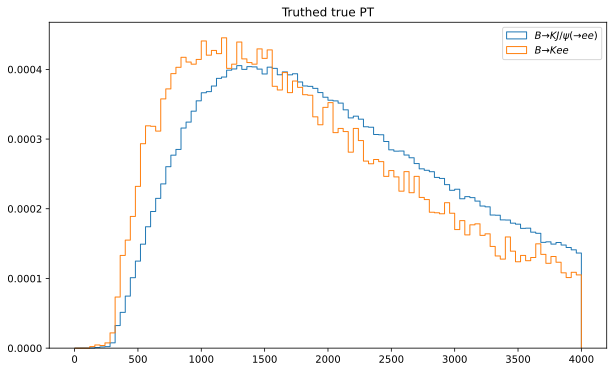

In [21]:
plt.hist(truthed[0]['e_minus_TRUEPT'], label=df_index[0], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(truthed[2]['e_minus_TRUEPT'], label=df_index[2], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.title('Truthed true PT')
plt.legend()
plt.show()

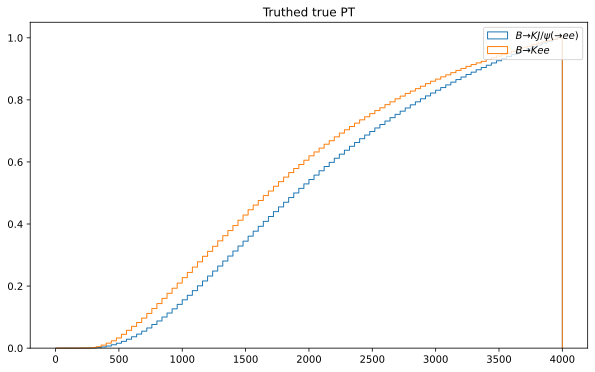

In [22]:
plt.hist(truthed[0]['e_minus_TRUEPT'], label=df_index[0], density=True, bins=list(np.linspace(0, 4000, 101)), histtype='step', cumulative=True)
plt.hist(truthed[2]['e_minus_TRUEPT'], label=df_index[2], density=True, bins=list(np.linspace(0, 4000, 101)), histtype='step', cumulative=True)
plt.title('Truthed true PT')
plt.legend()
plt.show()

### Preprocessing

In [23]:
import sklearn.preprocessing
import sklearn.model_selection

In [24]:
x0 = truthed[0]['e_minus_TRUEPT']
x1 = truthed[2]['e_minus_TRUEPT']
y0 = np.zeros_like(x0)
y1 = np.ones_like(x1)
X = np.hstack([x0, x1]).reshape(-1, 1)
Y = np.hstack([y0, y1])

In [25]:
x0.shape, x1.shape

((696573,), (40094,))

In [26]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.2)

In [27]:
y_train.mean(), y_test.mean()

(0.054425935761275884, 0.05442735553232791)

In [28]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)

StandardScaler()

### NN

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [30]:
def model():
    return nn.Sequential(
        nn.Linear(1, 20), nn.SELU(),
        nn.Linear(20, 20), nn.SELU(),
        nn.Linear(20, 20), nn.SELU(),
        nn.Linear(20, 1)
    )

In [31]:
def train(model, loader, epochs=20, pos_weight=1):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        for batch in loader:
            x, y = batch
            w = torch.ones_like(y)*pos_weight
            pred = model(x)[:,0]
            loss = F.binary_cross_entropy_with_logits(input=pred, target=y, pos_weight=w)
            opt.zero_grad()
            loss.backward()
            opt.step()

In [32]:
dataset = torch.utils.data.TensorDataset(
    torch.as_tensor(scaler.transform(x_train), dtype=torch.float),
    torch.as_tensor(y_train, dtype=torch.float)
)
loader = torch.utils.data.DataLoader(dataset, batch_size=100)
pos_weight = 1/y_train.mean() - 1 #   #neg/#pos = (#total/#pos - 1)

In [33]:
m = model()

In [34]:
train(m, loader, epochs=20, pos_weight=pos_weight)

In [35]:
m.eval()

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): SELU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): SELU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): SELU()
  (6): Linear(in_features=20, out_features=1, bias=True)
)

In [36]:
x = np.linspace(0, 10000, 1001)
x_ = scaler.transform(x.reshape(-1, 1))
y = torch.sigmoid(m(torch.as_tensor(x_, dtype=torch.float))[:, 0]).detach().numpy()

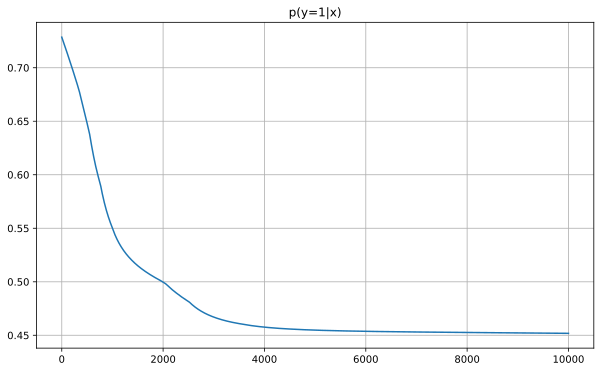

In [37]:
plt.plot(x, y)
plt.grid()
plt.title("p(y=1|x)")
plt.show()

### Reweighting

In [38]:
def weighting_fn(arr):
    arr_ = scaler.transform(np.asarray(arr).reshape(-1, 1))
    pred = torch.sigmoid(m(torch.as_tensor(arr_, dtype=torch.float))[:, 0]).detach().numpy()
    return 1+np.tanh(10*(2*pred-1))

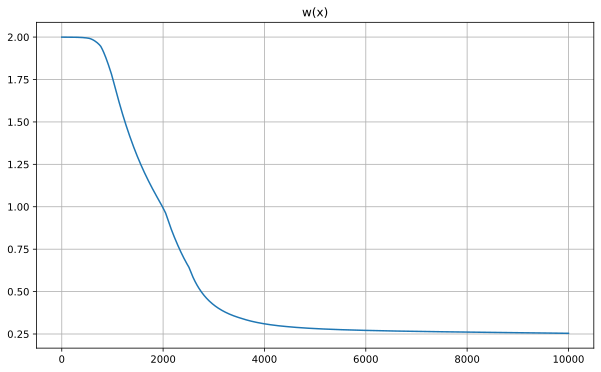

In [39]:
plt.plot(x, weighting_fn(x))
plt.grid()
plt.title("w(x)")
plt.show()

In [40]:
a0 = truthed[0]['e_minus_TRUEPT']
a2 = truthed[2]['e_minus_TRUEPT']
w0 = weighting_fn(a0)
w2 = weighting_fn(a2)
w0.mean(), w2.mean()

(0.88178205, 1.0042063)

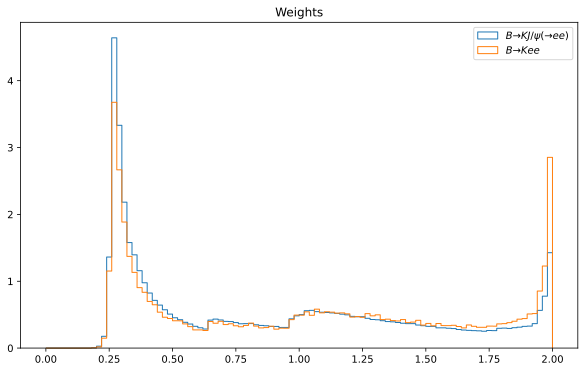

In [41]:
plt.hist(w0, label=df_index[0], density=True, bins=np.linspace(0, 2, 101), histtype='step', cumulative=False)
plt.hist(w2, label=df_index[2], density=True, bins=np.linspace(0, 2, 101), histtype='step', cumulative=False)
plt.title('Weights')
plt.legend()
plt.show()

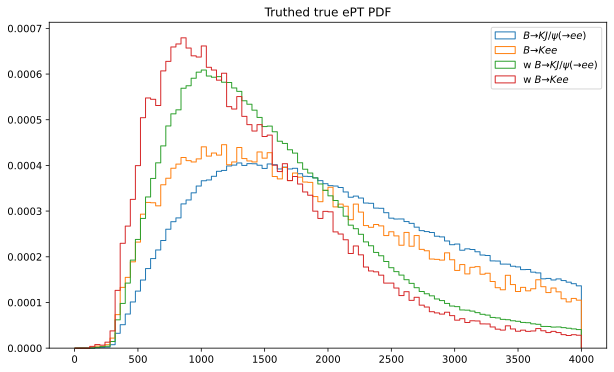

In [42]:
plt.hist(a0, label=df_index[0], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a2, label=df_index[2], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a0, weights=w0, label="w %s"%df_index[0], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.hist(a2, weights=w2, label="w %s"%df_index[2], density=True, bins=np.linspace(0, 4000, 101), histtype='step')
plt.title('Truthed true ePT PDF')
plt.legend()
plt.show()

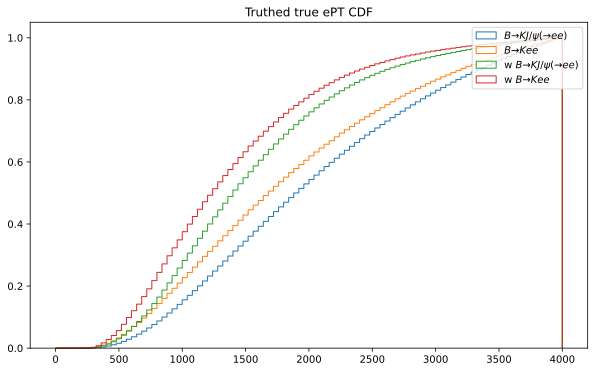

In [43]:
plt.hist(a0, label=df_index[0], density=True, bins=list(np.linspace(0, 4000, 101)), histtype='step', cumulative=True)
plt.hist(a2, label=df_index[2], density=True, bins=list(np.linspace(0, 4000, 101)), histtype='step', cumulative=True)
plt.hist(a0, weights=w0, label="w %s"%df_index[0], density=True, bins=list(np.linspace(0, 4000, 101)), histtype='step', cumulative=True)
plt.hist(a2, weights=w2, label="w %s"%df_index[2], density=True, bins=list(np.linspace(0, 4000, 101)), histtype='step', cumulative=True)
plt.title('Truthed true ePT CDF')
plt.legend()
plt.show()